#### Libraries

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.offline import init_notebook_mode, iplot
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, validation_curve
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,roc_auc_score
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

#### Informations about dataset


### Terminology 

    - BHK: Number of Bedrooms, Hall, Kitchen.

    - Rent: Rent of the Houses/Apartments/Flats.

    -Size: Size of the Houses/Apartments/Flats in Square Feet.
    
    -Floor: Houses/Apartments/Flats situated in which Floor and Total Number of Floors (Example: Ground out of 2, 3 out of 5, etc.)
    
    -Area Type: Size of the Houses/Apartments/Flats calculated on either Super Area or Carpet Area or Build Area.
    
    -Area Locality: Locality of the Houses/Apartments/Flats.
    
    -City: City where the Houses/Apartments/Flats are Located.
    
    -Furnishing Status: Furnishing Status of the Houses/Apartments/Flats, either it is Furnished or Semi-Furnished or Unfurnished.
    
    -Tenant Preferred: Type of Tenant Preferred by the Owner or Agent.
    
    -Bathroom: Number of Bathrooms.
    
    -Point of Contact: Whom should you contact for more information regarding the Houses/Apartments/Flats.

In [44]:
df = pd.read_csv(r'C:\Users\Mayana Maranhão\Documents\GitHub\Projetos\House Prediction\House_Rent_Dataset.csv')
df.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


### Checking missing values

In [45]:
df.isna().sum()

Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64

In [47]:
# Categoric variables effect on target
def target_summary_with_cat(dataframe, target, categorical_col, plot=False):

    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby([categorical_col])[target].mean(),
                        "TARGET_SUM" : dataframe.groupby([categorical_col])[target].sum()}), end="\n\n\n")

In [48]:
for col in cat_cols:
    target_summary_with_cat(df,'Rent',col)

              TARGET_MEAN  TARGET_SUM
Area Type                            
Built Area   10500.000000       21000
Carpet Area  52385.897302   120382792
Super Area   18673.396566    45675128


            TARGET_MEAN  TARGET_SUM
City                               
Bangalore  24966.365688    22120200
Chennai    21614.092031    19258156
Delhi      29461.983471    17824500
Hyderabad  20555.048387    17841782
Kolkata    11645.173664     6102071
Mumbai     85321.204733    82932211


                    TARGET_MEAN  TARGET_SUM
Furnishing Status                          
Furnished          56110.305882    38155008
Semi-Furnished     38718.810751    87156043
Unfurnished        22461.635813    40767869


                   TARGET_MEAN  TARGET_SUM
Tenant Preferred                          
Bachelors         42143.793976    34979349
Bachelors/Family  31210.792683   107489970
Family            50020.341102    23609601


                   TARGET_MEAN  TARGET_SUM
Point of Contact                    

In [49]:
# Examine Some Variables

df['Area Type'].value_counts()

Super Area     2446
Carpet Area    2298
Built Area        2
Name: Area Type, dtype: int64

In [39]:
# We saw Built Area non functional we can replace with mode of area type
df['Area Type'].replace({'Built Area': 'Super Area'}, inplace=True)

In [50]:
df['Point of Contact'].value_counts()
df['Point of Contact'].replace({'Contact Builder': 'Contact Owner'}, inplace=True)

In [51]:
# Splitting posted on column and creating new variables
df['Post_Day'] = df['Posted On'].apply(lambda x: x.split('-')[-1])
df['Post_Month'] = df['Posted On'].apply(lambda x: x.split('-')[1])
df.drop('Posted On', axis=1, inplace=True)

In [53]:
# Floor Column
df['Floor'] = df['Floor'].apply(lambda x: x.split(' ')[0])
df['Floor'].replace({'Ground': 0, 'Upper': 2, 'Lower': 1}, inplace=True)

#### EDA 

In [54]:
## Grabbing Columns
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]


    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 4746
Variables: 13
cat_cols: 8
num_cols: 4
cat_but_car: 3
num_but_cat: 2


In [57]:
def num_plot(data, cat_length=16, remove=["Id"], hist_bins=12, figsize=(20, 4)):
    num_cols = [col for col in data.columns if data[col].dtypes != "O"
                and len(data[col].unique()) >= cat_length]

    if len(remove) > 0:
        num_cols = list(set(num_cols).difference(remove))

    for i in num_cols:
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        data.hist(str(i), bins=hist_bins, ax=axes[0])
        data.boxplot(str(i), ax=axes[1], vert=False);
        try:
            sns.kdeplot(np.array(data[str(i)]))
        except:
            ValueError

        axes[1].set_yticklabels([])
        axes[1].set_yticks([])
        axes[0].set_title(i + " | Histogram")
        axes[1].set_title(i + " | Boxplot")
        axes[2].set_title(i + " | Density")
        plt.show()

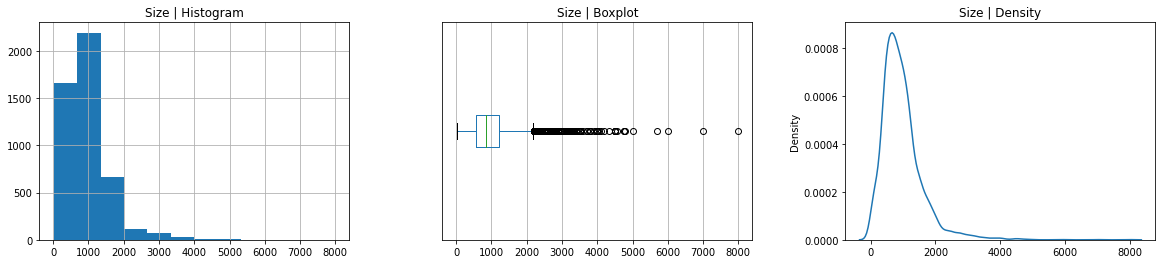

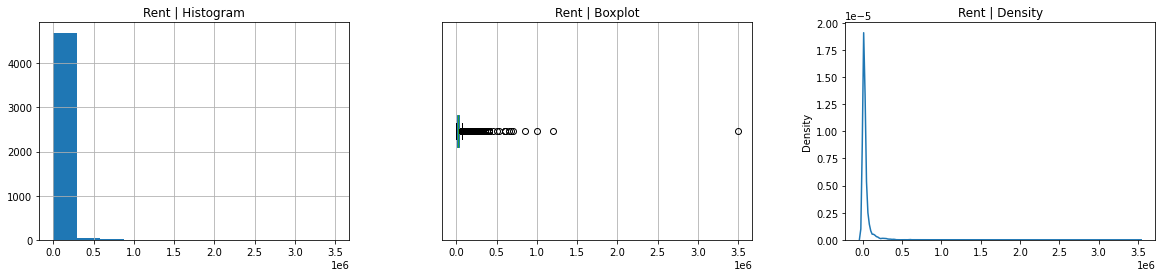

In [58]:
# Numeric Variable Analysis
num_plot(df)

<AxesSubplot: >

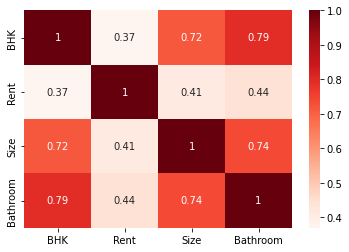

In [63]:
# Correlation Analysis
sns.heatmap(data=df.corr(),cmap='Reds',annot=True)

#### Outlier Analysis

In [64]:
# Checking outlier
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
for col in num_cols:
    print(col,check_outlier(df,col))

BHK True
Rent True
Size True
Bathroom True


In [65]:
# Replace Size variable with thresholds
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
replace_with_thresholds(df,'Rent')
replace_with_thresholds(df,'Size')

In [66]:
# Checking Again
for col in num_cols:
    print(col,check_outlier(df,col))
    
# Wee saw false

BHK True
Rent False
Size False
Bathroom True


#### Feature Engineering

In [67]:
# Dropping unnecesaary columns from dataset
df.drop(['Area Locality'], axis=1, inplace=True)

In [69]:
# Creating New Variables
df['Size_Per_Room'] = df['Size'] / (df['BHK'] + 1)
df['Size_Mul_Room'] = df['Size'] * (df['BHK']  + 1)

df['Room_Plus_Bath'] = df['BHK'] + df['Bathroom']
df['Room_Mul_Bath'] = (df['BHK'] + 1) * (df['Bathroom'] + 1)

df['Size_Per_RoomBath'] = df['Size'] / df['Room_Plus_Bath']
df['Size_Per_RoomMulBath'] = df['Size'] / df['Room_Mul_Bath']

df['CITY_RENT_MEAN'] = df.groupby('City')['Rent'].transform('mean')
df['CITY_RENT_MAX'] = df.groupby('City')['Rent'].transform('max')
df['CITY_RENT_MIN'] = df.groupby('City')['Rent'].transform('min')
df['CITY_SIZE_MEAN'] = df.groupby('City')['Size'].transform('mean')
df['CITY_SIZE_MAX'] = df.groupby('City')['Size'].transform('max')
df['CITY_SIZE_MIN'] = df.groupby('City')['Size'].transform('min')

df['Size_Mean_Rat'] = df['CITY_SIZE_MEAN'] / df['Size']
df['Size_Max_Rat'] = df['CITY_SIZE_MAX'] / df['Size']
df['Size_Min_Rat'] = df['CITY_SIZE_MIN'] / df['Size']

In [70]:
df.loc[(df['Size'] < 750), 'Area'] = 'Small'
df.loc[(df['Size'] >= 750) & (df['Size'] < 1500), 'Area'] = 'Middle'
df.loc[(df['Size'] >= 1500) & (df['Size'] <= df['Size'].max()), 'Area'] = 'Big'
df.groupby(by = 'Area')['Rent'].mean()

Area
Big       44800.005540
Middle    24953.780534
Small     16573.960062
Name: Rent, dtype: float64

In [72]:
df['Furnishing Status'].replace({'Unfurnished': 0, 'Semi-Furnished': 1, 'Furnished': 2}, inplace=True)
df['Size_Mul_Furn'] = df['Size'] * (df['Furnishing Status'] + 1)
df['Num_Plus_Furn'] = df['BHK'] + df['Furnishing Status']
df['Size_Mul_NumPlusFurn'] = df['Size'] * df['Num_Plus_Furn']
df['Bath_Plus_Furn'] = df['Bathroom'] + df['Furnishing Status']
df['Total_Num_Plus_Furn'] = df['Room_Plus_Bath'] + df['Furnishing Status']
df['Size_Per_Total'] = df['Size'] / df['Total_Num_Plus_Furn']

In [52]:
df.head()

,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Post_Day,Post_Month
0,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,18,05
1,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,13,05
2,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,16,05
3,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,04,07
4,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner,09,05


#### Encoding Categorical Variables with One Hot Encoding

In [73]:
def get_one_hot_vectors(dataframe, column):
    for i in range(len(column)):
        y = pd.get_dummies(dataframe[column[i]], prefix = column[i])
        dataframe = dataframe.merge(y, how='outer', left_index = True, right_index = True)
        dataframe = dataframe.drop(column[i], axis = 1)
        
    return dataframe

In [74]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 4746
Variables: 34
cat_cols: 16
num_cols: 26
cat_but_car: 2
num_but_cat: 10


In [78]:
columns = ['Area Type',
           'City',
           'Furnishing Status',
           'Tenant Preferred',
           'Point of Contact',
           'Post_Month',
           'Area',
           'CITY_RENT_MEAN',
           'CITY_RENT_MAX',
           'CITY_RENT_MIN',
           'CITY_SIZE_MEAN',
           'CITY_SIZE_MAX',
           'CITY_SIZE_MIN'      
           ]
df = get_one_hot_vectors(df, columns)
df.head()

,BHK,Rent,Size,Floor,Bathroom,Post_Day,Size_Per_Room,Size_Mul_Room,Room_Plus_Bath,Room_Mul_Bath,...,CITY_SIZE_MEAN_947.7945823927765,CITY_SIZE_MEAN_1000.8395061728395,CITY_SIZE_MEAN_1123.8352534562212,CITY_SIZE_MAX_2175,CITY_SIZE_MIN_10,CITY_SIZE_MIN_20,CITY_SIZE_MIN_25,CITY_SIZE_MIN_50,CITY_SIZE_MIN_80,CITY_SIZE_MIN_160
0,2,10000,1100,0,2,18,366.666667,3300,4,9,...,0,0,0,1,0,1,0,0,0,0
1,2,20000,800,1,1,13,266.666667,2400,3,6,...,0,0,0,1,0,1,0,0,0,0
2,2,17000,1000,1,1,16,333.333333,3000,3,6,...,0,0,0,1,0,1,0,0,0,0
3,2,10000,800,1,1,04,266.666667,2400,3,6,...,0,0,0,1,0,1,0,0,0,0
4,2,7500,850,1,1,09,283.333333,2550,3,6,...,0,0,0,1,0,1,0,0,0,0


#### Scaling

In [79]:
rs = RobustScaler()

In [80]:
sv = ['Rent',
      'Size',
      'Size_Per_Room',
      'Size_Mul_Room',
      'Size_Per_RoomBath',
      'Size_Per_RoomMulBath',
      'Size_Mean_Rat',
      'Size_Max_Rat',
      'Size_Min_Rat',
     'Size_Mul_Furn',
     'Num_Plus_Furn',
     'Size_Mul_NumPlusFurn',
     'Bath_Plus_Furn',
     'Total_Num_Plus_Furn',
     'Size_Per_Total',
     'Floor',
     'Post_Day'
     ]

In [81]:
df[sv] = rs.fit_transform(df[sv])
df.head()

,BHK,Rent,Size,Floor,Bathroom,Post_Day,Size_Per_Room,Size_Mul_Room,Room_Plus_Bath,Room_Mul_Bath,...,CITY_SIZE_MEAN_947.7945823927765,CITY_SIZE_MEAN_1000.8395061728395,CITY_SIZE_MEAN_1123.8352534562212,CITY_SIZE_MAX_2175,CITY_SIZE_MIN_10,CITY_SIZE_MIN_20,CITY_SIZE_MIN_25,CITY_SIZE_MIN_50,CITY_SIZE_MIN_80,CITY_SIZE_MIN_160
0,2,-0.260870,0.384615,-1.0,2,0.2500,0.588235,0.257378,4,9,...,0,0,0,1,0,1,0,0,0,0
1,2,0.173913,-0.076923,-0.5,1,-0.0625,-0.117647,-0.051476,3,6,...,0,0,0,1,0,1,0,0,0,0
2,2,0.043478,0.230769,-0.5,1,0.1250,0.352941,0.154427,3,6,...,0,0,0,1,0,1,0,0,0,0
3,2,-0.260870,-0.076923,-0.5,1,-0.6250,-0.117647,-0.051476,3,6,...,0,0,0,1,0,1,0,0,0,0
4,2,-0.369565,0.000000,-0.5,1,-0.3125,0.000000,0.000000,3,6,...,0,0,0,1,0,1,0,0,0,0


#### Modeling

In [82]:
X = df.drop('Rent',axis=1)
y = df['Rent']

In [83]:
# Splitting df test and train
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In [84]:
models = [('LR', LinearRegression()),
        ("Ridge", Ridge()),
        ("Lasso", Lasso()),
        ("ElasticNet", ElasticNet()),
        ('KNN', KNeighborsRegressor()),
        ('CART', DecisionTreeRegressor()),
        ('RF', RandomForestRegressor()),
        ('SVR', SVR()),
        ('GBM', GradientBoostingRegressor()),
        ("XGBoost", XGBRegressor(objective='reg:squarederror')),
        ("LightGBM", LGBMRegressor()),
        ("CatBoost", CatBoostRegressor(verbose=False))]

for name, regressor in models:
     rmse = np.mean(np.sqrt(-cross_val_score(regressor, X_train, y_train, cv=7, scoring="neg_mean_squared_error")))
     print(f"RMSE: {round(rmse, 4)} ({name}) ")

RMSE: 0.4108 (LR) 
RMSE: 0.4102 (Ridge) 
RMSE: 0.7046 (Lasso) 
RMSE: 0.6469 (ElasticNet) 
RMSE: 0.393 (KNN) 
RMSE: 0.5034 (CART) 
RMSE: 0.3682 (RF) 
RMSE: 0.3645 (SVR) 
RMSE: 0.358 (GBM) 
RMSE: 0.3823 (XGBoost) 
RMSE: 0.3609 (LightGBM) 
RMSE: 0.3519 (CatBoost) 


#### Hypermater Tuning For Cat Boost

 Hyperparameter tuning is an essential part of controlling the behavior of a machine learning model. If we don't correctly tune our hyperparameters, our estimated model parameters produce suboptimal results, as they don't minimize the loss function. This means our model makes more errors.

In [85]:
catboost_model = CatBoostRegressor(random_state=17, verbose=False)
catboost_params = {"iterations": [200, 500],
                    "learning_rate": [0.01, 0.1],
                    "depth": [3, 6]}

catboost_best_grid = GridSearchCV(catboost_model, catboost_params, cv=5, n_jobs=-1, verbose=True).fit(X_train, y_train)
catboost_final = catboost_model.set_params(**catboost_best_grid.best_params_, random_state=17).fit(X_train, y_train)
rmse = np.mean(np.sqrt(-cross_val_score(catboost_final, X_train, y_train, cv=10, scoring="neg_mean_squared_error")))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [87]:
catboost_final_pred = catboost_final.predict(X_test)

In [88]:
MAE = metrics.mean_absolute_error(y_test, catboost_final_pred)
MSE =  metrics.mean_squared_error(y_test, catboost_final_pred)
RMSE =  np.sqrt(MSE)

In [89]:
print('MAE:', MAE) # MEAN ABSOLUTE ERROR
print('MSE:', MSE) # MEAN SQUARED ERROR
print('RMSE:', RMSE) # ROOT MEAN SQUARED ERROR

MAE: 0.2194872682886521
MSE: 0.10369789451949199
RMSE: 0.32202157461805564


In [90]:
catboost_final.score(X_test,y_test)

0.8584850886172319

In [86]:
print(rmse)

0.34872406873675466


#### Feature Importance

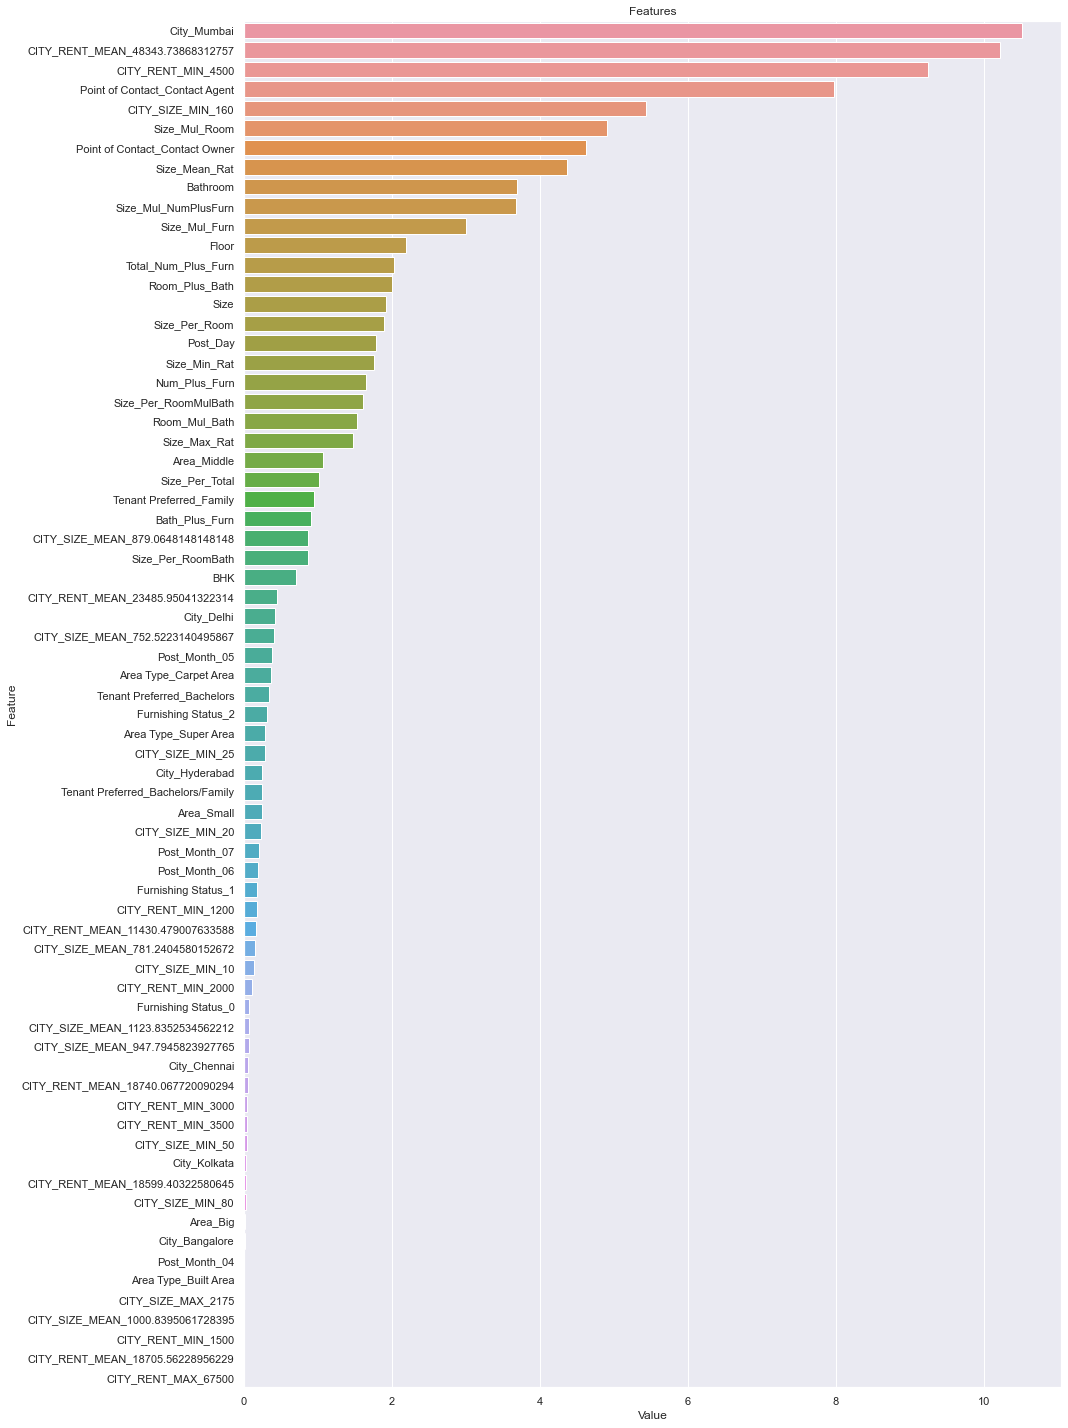

In [91]:
# Let's see if the new variables are effective.
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(15, 20))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')
        
plot_importance(catboost_final,X)